In [1]:
import pandas as pd

In [2]:
pheno = pd.read_csv('../data/phenotipic_combined.csv', index_col=0)
pheno.head()

,SEX,AGE_AT_SCAN,DX_GROUP,SITE_ID,HANDEDNESS_CATEGORY
SUB_ID,,,,,
51456,Male,55.4,Autism,CALTECH,R
51457,Male,22.9,Autism,CALTECH,M
51458,Male,39.2,Autism,CALTECH,R
51459,Male,22.8,Autism,CALTECH,R
51460,Female,34.6,Autism,CALTECH,M


In [41]:
thick = pd.read_csv('../data/ABIDE_ESHAPE/thick.csv', low_memory=False, index_col=0).join(pd.read_csv('../data/ABIDE_ESHAPE/LogJacs.csv', low_memory=False, index_col=0))
thick.shape

(2194, 54240)

In [42]:
thick.dropna(inplace=True)

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline

In [75]:
n_comp = 50

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_comp))
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50))])

In [76]:
x_pca = pipeline.fit_transform(thick, pheno.DX_GROUP.reindex(thick.index))

In [78]:
pca_cols = [f'PC{i+1}' for i in range(n_comp)]
df_pca = pd.DataFrame(x_pca, columns=pca_cols, index=thick.index)

In [79]:
df_pca_comp = df_pca.join(pheno.DX_GROUP)
df_pca_comp.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,DX_GROUP
SubjID,,,,,,,,,,,,,,,,,,,,,
28675,243.501564,-2.094617,40.233738,40.512640,1.784395,-60.409442,4.147771,47.314956,-9.110851,-0.639756,...,-18.272819,-11.422814,-10.169843,13.275145,15.691881,10.785964,-3.042839,-16.067527,-7.988438,Autism
28676,211.361043,29.958407,312.826349,125.328551,56.351658,-7.089197,18.890607,46.606046,10.823757,-8.408155,...,-24.796143,9.165371,23.789265,-9.183541,-3.985436,1.495248,23.967568,-6.237335,3.464756,Autism
28677,164.913886,-6.913498,218.443099,86.690717,72.031803,24.414711,85.570982,85.471724,30.056956,-46.115608,...,21.723613,-7.714448,-20.738735,-13.092466,-15.881159,16.530586,4.250096,-46.897642,43.960585,Autism
28678,231.331250,-31.562860,56.542594,10.341554,-12.616762,-1.129031,-30.647842,45.674038,-6.351706,-3.108785,...,8.331466,17.099877,-10.480189,4.345443,5.505751,-3.436628,4.498827,-13.194517,13.913924,Autism
28679,39.209354,-28.848956,11.327131,46.963265,-27.813714,-59.477788,5.090726,23.862841,-44.542831,-41.769246,...,-24.023970,-9.977174,-4.884660,-14.777992,-5.357273,9.230966,-8.769805,-9.778308,-18.329277,Autism


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [84]:
# sns.pairplot(df_pca_comp, hue='DX_GROUP', corner=True)

<AxesSubplot:xlabel='variable', ylabel='value'>

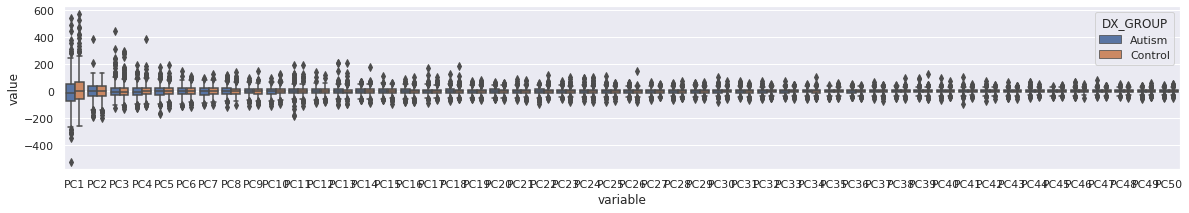

In [85]:
plt.figure(figsize=(20,3))
sns.boxplot(data=df_pca_comp.melt(id_vars='DX_GROUP'), x='variable', y='value', hue='DX_GROUP')

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [87]:
X = df_pca_comp.drop(columns='DX_GROUP')
y = df_pca_comp['DX_GROUP']

# X = thick
# y = pheno.DX_GROUP.reindex(thick.index)

In [88]:
skf = StratifiedKFold(n_splits=10)

In [89]:
accs = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    accs.append(model.score(X_test, y_test))

sum(accs) / len(accs)

              precision    recall  f1-score   support

      Autism       0.57      0.47      0.52       104
     Control       0.59      0.68      0.63       116

    accuracy                           0.58       220
   macro avg       0.58      0.58      0.57       220
weighted avg       0.58      0.58      0.58       220

              precision    recall  f1-score   support

      Autism       0.55      0.58      0.56       104
     Control       0.60      0.57      0.58       116

    accuracy                           0.57       220
   macro avg       0.57      0.57      0.57       220
weighted avg       0.57      0.57      0.57       220

              precision    recall  f1-score   support

      Autism       0.63      0.38      0.47       104
     Control       0.59      0.80      0.68       116

    accuracy                           0.60       220
   macro avg       0.61      0.59      0.57       220
weighted avg       0.61      0.60      0.58       220

              preci

0.5576463262764633

In [96]:
model.feature_importances_.shape, df_pca.columns.shape

((50,), (50,))

In [99]:
pd.Series(model.feature_importances_, index=df_pca.columns, name='feature_importances').sort_values(ascending=False)

PC7     0.026245
PC13    0.026216
PC1     0.025946
PC18    0.025348
PC16    0.023207
PC4     0.023205
PC32    0.023096
PC5     0.022107
PC15    0.022066
PC41    0.021618
PC49    0.021419
PC45    0.021205
PC34    0.021154
PC6     0.020888
PC50    0.020758
PC26    0.020604
PC8     0.020366
PC3     0.020328
PC22    0.020229
PC17    0.020194
PC33    0.019882
PC2     0.019837
PC35    0.019417
PC27    0.019416
PC39    0.019400
PC46    0.019195
PC43    0.019142
PC42    0.018863
PC40    0.018820
PC19    0.018778
PC31    0.018552
PC37    0.018481
PC14    0.018478
PC12    0.018413
PC48    0.018386
PC10    0.018346
PC28    0.018293
PC38    0.018277
PC23    0.018245
PC11    0.018213
PC20    0.018203
PC47    0.018164
PC24    0.018099
PC25    0.017985
PC30    0.017985
PC29    0.017950
PC9     0.017678
PC44    0.017493
PC36    0.016927
PC21    0.016885
Name: feature_importances, dtype: float64

<AxesSubplot:>

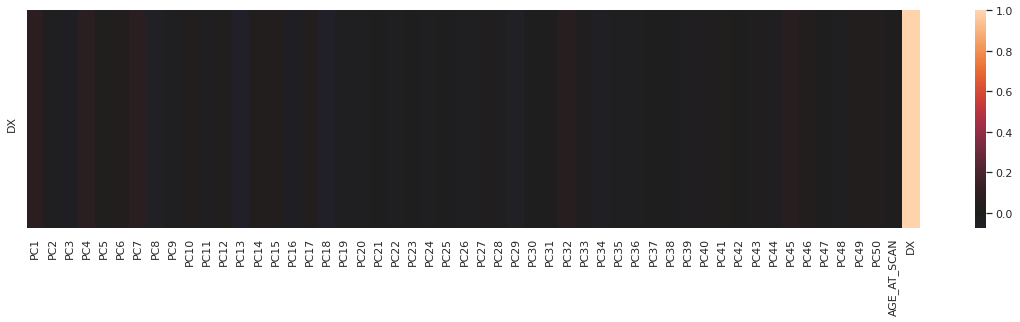

In [113]:
plt.figure(figsize=(20, 4))
pheno['DX'] = pheno.DX_GROUP.astype('category').cat.codes
sns.heatmap(df_pca.join(pheno).corr().loc[['DX'], :], center=0)

In [114]:
df_pca.join(pheno).corr().loc[['DX'], :]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,AGE_AT_SCAN,DX
DX,0.079048,-0.012419,-0.039866,0.07102,0.018733,0.032987,0.068581,-0.057049,-0.031864,0.036,...,0.013396,-0.017526,0.060576,0.0283,-0.009523,-0.033388,0.035687,0.036412,0.004402,1.0
